# D-03 EDA — Migrants by Last Residence, Duration & Reason (Census 2011)

**File:** DS-0000-D03-MDDS.XLSX  
**What this has:** Same structure as D-02 but instead of duration bands, the columns give reason for migration (Work, Business, Education, Marriage etc.) broken down by sex.

Three grouping columns inflate the rows — TRU (place of enumeration), Duration, and Dest_TRU (last-residence TRU) — so each (state, last-residence) pair appears up to 45 times. We only want TRU=Total, Duration='All durations of residence', Dest_TRU=Total.

Note on duration: D-03 only has 4 named duration bands (<1yr, 1-4yr, 5-9yr, 10+yr) — there's no separate "not stated" band, so the 4 bands won't sum to the 'All durations' total. About 72.7M migrants with unrecorded duration are only in the aggregate row. That's just how the table is structured, not a data problem.

Also note: D-03 uses 'Other Countries' as a single catch-all for all foreign origins (unlike D-02 which has per-continent rows). 'Other Countries' is an actual data row so we keep it.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import warnings
warnings.filterwarnings('ignore')

plt.rcParams.update({
    'figure.dpi': 120,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.titlesize': 13,
    'axes.labelsize': 11,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
})

INPUT_FILE = "DS-0000-D03-MDDS.XLSX"
SKIP_ROWS  = 5

COL_NAMES = [
    'TableName','StateCode','DistrictCode','AreaName',
    'TRU','Duration','LastResidence','Dest_TRU',
    'Persons_Total','Males_Total','Females_Total',
    'Persons_Work','Males_Work','Females_Work',
    'Persons_Business','Males_Business','Females_Business',
    'Persons_Education','Males_Education','Females_Education',
    'Persons_Marriage','Males_Marriage','Females_Marriage',
    'Persons_MoveAfterBirth','Males_MoveAfterBirth','Females_MoveAfterBirth',
    'Persons_MoveWithHH','Males_MoveWithHH','Females_MoveWithHH',
    'Persons_Other','Males_Other','Females_Other',
]

df_raw = pd.read_excel(INPUT_FILE, skiprows=SKIP_ROWS, header=None)
df_raw.columns = COL_NAMES[:df_raw.shape[1]]
print(f"Raw shape: {df_raw.shape}")
df_raw.head(8)


Raw shape: (67503, 32)


,TableName,StateCode,DistrictCode,AreaName,TRU,Duration,LastResidence,Dest_TRU,Persons_Total,Males_Total,...,Females_Marriage,Persons_MoveAfterBirth,Males_MoveAfterBirth,Females_MoveAfterBirth,Persons_MoveWithHH,Males_MoveWithHH,Females_MoveWithHH,Persons_Other,Males_Other,Females_Other
0,D0603,0.0,0.0,INDIA,Total,All durations of residence,Total,Total,455787621.0,146145967.0,...,205839698.0,33855865.0,20078947.0,13776918.0,65959915.0,29679662.0,36280253.0,94314450.0,50044441.0,44270009.0
1,D0603,0.0,0.0,INDIA,Total,All durations of residence,Last residence within India,Total,449917418.0,143467652.0,...,204539247.0,33677964.0,19973771.0,13704193.0,64038586.0,28722224.0,35316362.0,92600066.0,49061161.0,43538905.0
2,D0603,0.0,0.0,INDIA,Total,All durations of residence,Last residence within India,Rural,291960709.0,72214492.0,...,170626957.0,18270441.0,11139600.0,7130841.0,36634916.0,16452832.0,20182084.0,30436449.0,14478605.0,15957844.0
3,D0603,0.0,0.0,INDIA,Total,All durations of residence,Last residence within India,Urban,105075338.0,45334257.0,...,26689631.0,14025619.0,8015359.0,6010260.0,24636084.0,10929968.0,13706116.0,22456804.0,12151159.0,10305645.0
4,D0603,0.0,0.0,INDIA,Total,All durations of residence,Within the state of enumeration but outside th...,Total,395652669.0,119597840.0,...,188081771.0,31169664.0,18498156.0,12671508.0,50986201.0,23503679.0,27482522.0,84955928.0,44802500.0,40153428.0
5,D0603,0.0,0.0,INDIA,Total,All durations of residence,Within the state of enumeration but outside th...,Rural,260325223.0,58461657.0,...,159742013.0,17078287.0,10423555.0,6654732.0,29517385.0,13610126.0,15907259.0,27192976.0,12585767.0,14607209.0
6,D0603,0.0,0.0,INDIA,Total,All durations of residence,Within the state of enumeration but outside th...,Urban,85378046.0,36555762.0,...,21632159.0,12815978.0,7317326.0,5498652.0,19123505.0,8735455.0,10388050.0,19558434.0,10558934.0,8999500.0
7,D0603,0.0,0.0,INDIA,Total,All durations of residence,Elsewhere in the district of enumeration,Total,277513908.0,82948766.0,...,133692581.0,22785819.0,13556946.0,9228873.0,30799296.0,14885986.0,15913310.0,68262980.0,36969817.0,31293163.0


## 1. Raw snapshot

In [2]:
print(df_raw.dtypes)
print()
print(df_raw.isnull().sum())
print()
print(f"Duplicate rows: {df_raw.duplicated().sum()}")


TableName                  object
StateCode                 float64
DistrictCode              float64
AreaName                   object
TRU                        object
Duration                   object
LastResidence              object
Dest_TRU                   object
Persons_Total             float64
Males_Total               float64
Females_Total             float64
Persons_Work              float64
Males_Work                float64
Females_Work              float64
Persons_Business          float64
Males_Business            float64
Females_Business          float64
Persons_Education         float64
Males_Education           float64
Females_Education         float64
Persons_Marriage          float64
Males_Marriage            float64
Females_Marriage          float64
Persons_MoveAfterBirth    float64
Males_MoveAfterBirth      float64
Females_MoveAfterBirth    float64
Persons_MoveWithHH        float64
Males_MoveWithHH          float64
Females_MoveWithHH        float64
Persons_Other 

Duplicate rows: 0


In [3]:
num_cols = [c for c in df_raw.columns if c.startswith(('Persons_','Males_','Females_'))]
df_raw[num_cols].describe()


,Persons_Total,Males_Total,Females_Total,Persons_Work,Males_Work,Females_Work,Persons_Business,Males_Business,Females_Business,Persons_Education,...,Females_Marriage,Persons_MoveAfterBirth,Males_MoveAfterBirth,Females_MoveAfterBirth,Persons_MoveWithHH,Males_MoveWithHH,Females_MoveWithHH,Persons_Other,Males_Other,Females_Other
count,6.750000e+04,6.750000e+04,6.750000e+04,6.750000e+04,6.750000e+04,6.750000e+04,6.750000e+04,6.750000e+04,67500.000000,6.750000e+04,...,6.750000e+04,6.750000e+04,6.750000e+04,6.750000e+04,6.750000e+04,6.750000e+04,6.750000e+04,6.750000e+04,6.750000e+04,6.750000e+04
mean,3.331503e+05,9.909499e+04,2.340553e+05,3.288667e+04,2.789909e+04,4.987587e+03,2.783074e+03,2.093356e+03,689.718578,4.099225e+03,...,1.642322e+05,2.552195e+04,1.515057e+04,1.037138e+04,5.113416e+04,2.283426e+04,2.829990e+04,4.831286e+04,2.445186e+04,2.386100e+04
std,5.404371e+06,1.539718e+06,3.958912e+06,4.704511e+05,4.016569e+05,7.133452e+04,4.151334e+04,3.162449e+04,10393.462558,6.267641e+04,...,2.975463e+06,4.128979e+05,2.497210e+05,1.641779e+05,7.289503e+05,3.301527e+05,3.998359e+05,9.352302e+05,4.869691e+05,4.508496e+05
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.300000e+01,6.000000e+00,6.000000e+00,3.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,...,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
50%,1.990000e+02,1.000000e+02,9.100000e+01,4.400000e+01,3.800000e+01,5.000000e+00,2.000000e+00,2.000000e+00,0.000000,4.000000e+00,...,2.000000e+01,4.000000e+00,2.000000e+00,2.000000e+00,6.000000e+01,2.300000e+01,3.800000e+01,2.700000e+01,1.600000e+01,1.000000e+01
75%,4.207000e+03,1.982000e+03,2.104000e+03,9.190000e+02,7.822500e+02,1.140000e+02,5.900000e+01,4.500000e+01,11.000000,7.900000e+01,...,6.810000e+02,1.200000e+02,6.600000e+01,5.300000e+01,1.178250e+03,4.600000e+02,7.170000e+02,5.390000e+02,3.090000e+02,2.202500e+02
max,4.557876e+08,1.461460e+08,3.096417e+08,4.142292e+07,3.501670e+07,6.406217e+06,3.590487e+06,2.683144e+06,907343.000000,5.457556e+06,...,2.058397e+08,3.385586e+07,2.007895e+07,1.377692e+07,6.595992e+07,2.967966e+07,3.628025e+07,9.431445e+07,5.004444e+07,4.427001e+07


## 2. Checking the three grouping axes

In [4]:
for col in ['TRU','Duration','Dest_TRU']:
    print(f"=== {col} ===")
    print(df_raw[col].value_counts().to_string())
    print()


=== TRU ===
TRU
Total    22500
Rural    22500
Urban    22500

=== Duration ===
Duration
All durations of residence                  13500
Duration of residence less than 1 year      13500
Duration of residence 1-4 years             13500
Duration of residence 5-9 years             13500
Duration of residence 10 years and above    13500

=== Dest_TRU ===
Dest_TRU
Total    24300
Rural    21600
Urban    21600



In [5]:
SUMMARY_LR = {
    'Total','Last residence within India',
    'Within the state of enumeration but outside the place of enumeration',
    'Elsewhere in the district of enumeration',
    'In other districts of the state of enumeration',
    'States in India beyond the state of enumeration',
    'Last residence outside India',
    'Countries in Asia beyond India','Countries in Europe',
    'Countries in Africa','Countries in the Americas',
    'Countries in Oceania','Elsewhere','Unclassifiable'
}
# 'Other Countries' is NOT in this set - it's the actual foreign-origin row in D03

print("LastResidence values:")
for v in sorted(df_raw['LastResidence'].dropna().astype(str).str.strip().unique()):
    if v in SUMMARY_LR:
        note = "  <- subtotal"
    elif v == 'Other Countries':
        note = "  <- foreign aggregate, keep"
    else:
        note = ""
    print(f"  {v}{note}")


LastResidence values:
  Andaman & Nicobar Islands
  Andhra Pradesh
  Arunachal Pradesh
  Assam
  Bihar
  Chandigarh
  Chhattisgarh
  Countries in Asia beyond India  <- subtotal
  Dadra & Nagar Haveli
  Daman & Diu
  Elsewhere in the district of enumeration  <- subtotal
  Goa
  Gujarat
  Haryana
  Himachal Pradesh
  In other districts of the state of enumeration  <- subtotal
  Jammu & Kashmir
  Jharkhand
  Karnataka
  Kerala
  Lakshadweep
  Last residence outside India  <- subtotal
  Last residence within India  <- subtotal
  Madhya Pradesh
  Maharashtra
  Manipur
  Meghalaya
  Mizoram
  NCT of Delhi
  Nagaland
  Odisha
  Other Countries  <- foreign aggregate, keep
  Puducherry
  Punjab
  Rajasthan
  Sikkim
  States in India beyond the state of enumeration  <- subtotal
  Tamil Nadu
  Total  <- subtotal
  Tripura
  Unclassifiable  <- subtotal
  Uttar Pradesh
  Uttarakhand
  West Bengal
  Within the state of enumeration but outside the place of enumeration  <- subtotal


## 3. Verifying the grouping hierarchy

Two things to check: (1) does the Dest_TRU split add up, and (2) do the duration bands add up to 'All durations'.

In [6]:
india_lriw = df_raw[
    (df_raw['AreaName'].astype(str).str.strip() == 'INDIA') &
    (df_raw['TRU'].astype(str).str.strip() == 'Total') &
    (df_raw['Duration'].astype(str).str.strip() == 'All durations of residence') &
    (df_raw['LastResidence'].astype(str).str.strip() == 'Last residence within India')
].copy()
india_lriw['Persons_Total'] = pd.to_numeric(india_lriw['Persons_Total'], errors='coerce')

print("Dest_TRU rows for 'Last residence within India':")
for _, row in india_lriw.sort_values('Dest_TRU').iterrows():
    note = "  <- keeping this" if row['Dest_TRU'] == 'Total' else "  <- sub-slice"
    print(f"  {row['Dest_TRU']:<6}: {row['Persons_Total']:>15,.0f}{note}")

tt = float(india_lriw[india_lriw['Dest_TRU']=='Total']['Persons_Total'].values[0])
tr = float(india_lriw[india_lriw['Dest_TRU']=='Rural']['Persons_Total'].values[0])
tu = float(india_lriw[india_lriw['Dest_TRU']=='Urban']['Persons_Total'].values[0])
print(f"  Rural + Urban = {tr+tu:,.0f}  (gap {tt-tr-tu:,.0f} = unclassified within-state)")
print()

india_dur = df_raw[
    (df_raw['AreaName'].astype(str).str.strip() == 'INDIA') &
    (df_raw['TRU'].astype(str).str.strip() == 'Total') &
    (df_raw['LastResidence'].astype(str).str.strip() == 'Total') &
    (df_raw['Dest_TRU'].astype(str).str.strip() == 'Total')
].copy()
india_dur['Persons_Total'] = pd.to_numeric(india_dur['Persons_Total'], errors='coerce')

all_dur   = float(india_dur[india_dur['Duration']=='All durations of residence']['Persons_Total'].values[0])
named_sum = india_dur[india_dur['Duration']!='All durations of residence']['Persons_Total'].sum()

print("Duration bands:")
for _, row in india_dur.iterrows():
    note = "  <- our target row" if row['Duration'] == 'All durations of residence' else ""
    print(f"  {str(row['Duration']):<45}: {row['Persons_Total']:>15,.0f}{note}")
print(f"  sum of 4 named bands: {named_sum:,.0f}  (gap {all_dur-named_sum:,.0f} = no-duration-stated migrants)")


Dest_TRU rows for 'Last residence within India':
  Rural :     291,960,709  <- sub-slice
  Total :     449,917,418  <- keeping this
  Urban :     105,075,338  <- sub-slice
  Rural + Urban = 397,036,047  (gap 52,881,371 = unclassified within-state)

Duration bands:
  All durations of residence                   :     455,787,621  <- our target row
  Duration of residence less than 1 year       :      17,586,044
  Duration of residence 1-4 years              :      63,893,251
  Duration of residence 5-9 years              :      60,428,975
  Duration of residence 10 years and above     :     241,134,689
  sum of 4 named bands: 383,042,959  (gap 72,744,662 = no-duration-stated migrants)


## 4. Cleaning

In [7]:
df = df_raw.copy()

df = df[
    (df['TRU'].astype(str).str.strip()      == 'Total') &
    (df['Duration'].astype(str).str.strip() == 'All durations of residence') &
    (df['Dest_TRU'].astype(str).str.strip() == 'Total')
]

df = df.dropna(subset=['AreaName','LastResidence'])
df = df[df['AreaName'].astype(str).str.strip() != 'INDIA']

SUMMARY_LR = {
    'Total','Last residence within India',
    'Within the state of enumeration but outside the place of enumeration',
    'Elsewhere in the district of enumeration',
    'In other districts of the state of enumeration',
    'States in India beyond the state of enumeration',
    'Last residence outside India',
    'Countries in Asia beyond India','Countries in Europe',
    'Countries in Africa','Countries in the Americas',
    'Countries in Oceania','Elsewhere','Unclassifiable',
}
df = df[~df['LastResidence'].astype(str).str.strip().isin(SUMMARY_LR)]

num_cols = [c for c in df.columns if c.startswith(('Persons_','Males_','Females_'))]
for col in num_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(int)

df = df[df['Persons_Total'] > 0]

df['AreaName']     = df['AreaName'].astype(str).str.replace(r'^State\s*-\s*', '', regex=True).str.replace(r'\s*\(\d+\)\s*$', '', regex=True).str.strip()
df['LastResidence'] = df['LastResidence'].astype(str).str.strip()

print(f"Rows: {len(df)}")
print(f"States: {df['AreaName'].nunique()},  LastResidence categories: {df['LastResidence'].nunique()}")


Rows: 1208
States: 35,  LastResidence categories: 36


## 5. Validation checks

In [8]:
dupes = df.duplicated(subset=['AreaName','LastResidence'])
print(f"Duplicate (state, last-residence) pairs: {dupes.sum()}")

reason_cols = ['Persons_Work','Persons_Business','Persons_Education',
               'Persons_Marriage','Persons_MoveAfterBirth',
               'Persons_MoveWithHH','Persons_Other']
df['_rsum'] = df[reason_cols].sum(axis=1)
reason_bad = (abs(df['Persons_Total'] - df['_rsum']) > 1).sum()
print(f"Rows where reason columns don't sum to Total: {reason_bad}")
df.drop(columns=['_rsum'], inplace=True)

mf_bad = (abs(df['Persons_Total'] - df['Males_Total'] - df['Females_Total']) > 1).sum()
print(f"M+F != Total: {mf_bad}")

rps = df.groupby('AreaName').size()
print(f"Rows per state — min {rps.min()}, max {rps.max()}, mean {rps.mean():.1f}")


Duplicate (state, last-residence) pairs: 0
Rows where reason columns don't sum to Total: 0
M+F != Total: 0
Rows per state — min 31, max 35, mean 34.5


## 6. EDA

In [9]:
print(f"States / UTs      : {df['AreaName'].nunique()}")
print(f"LastResidence cats: {df['LastResidence'].nunique()}")
print(f"Total rows        : {len(df):,}")
print(f"Total migrants    : {df['Persons_Total'].sum():,}")


States / UTs      : 35
LastResidence cats: 36
Total rows        : 1,208
Total migrants    : 55,246,933


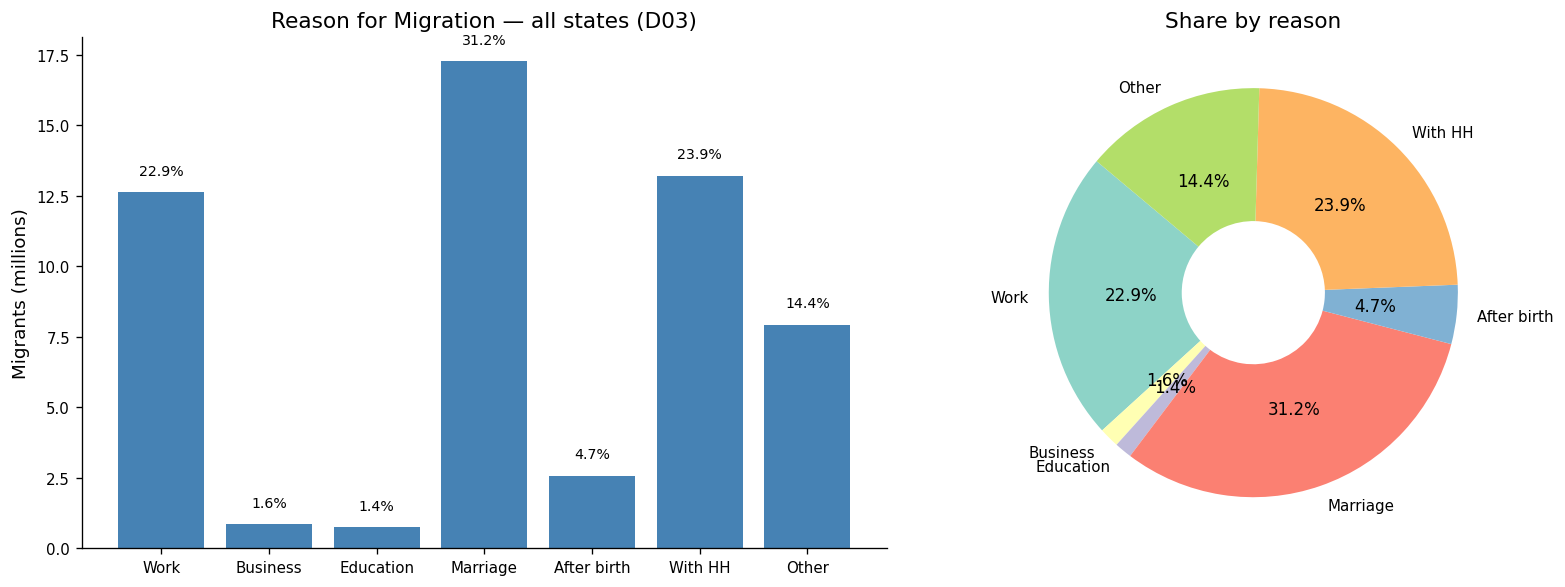

In [10]:
reason_cols   = ['Persons_Work','Persons_Business','Persons_Education',
                 'Persons_Marriage','Persons_MoveAfterBirth','Persons_MoveWithHH','Persons_Other']
reason_labels = ['Work','Business','Education','Marriage','After birth','With HH','Other']
reason_totals = df[reason_cols].sum()
grand = reason_totals.sum()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

bars = axes[0].bar(reason_labels, reason_totals.values / 1e6, color='steelblue')
for bar, val in zip(bars, reason_totals.values):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                 f"{val/grand*100:.1f}%", ha='center', va='bottom', fontsize=8.5)
axes[0].set_ylabel('Migrants (millions)')
axes[0].set_title('Reason for Migration — all states (D03)')

axes[1].pie(reason_totals.values, labels=reason_labels, autopct='%1.1f%%',
            colors=plt.cm.Set3.colors[:len(reason_labels)],
            startangle=140, wedgeprops=dict(width=0.65))
axes[1].set_title('Share by reason')

plt.tight_layout()
plt.show()


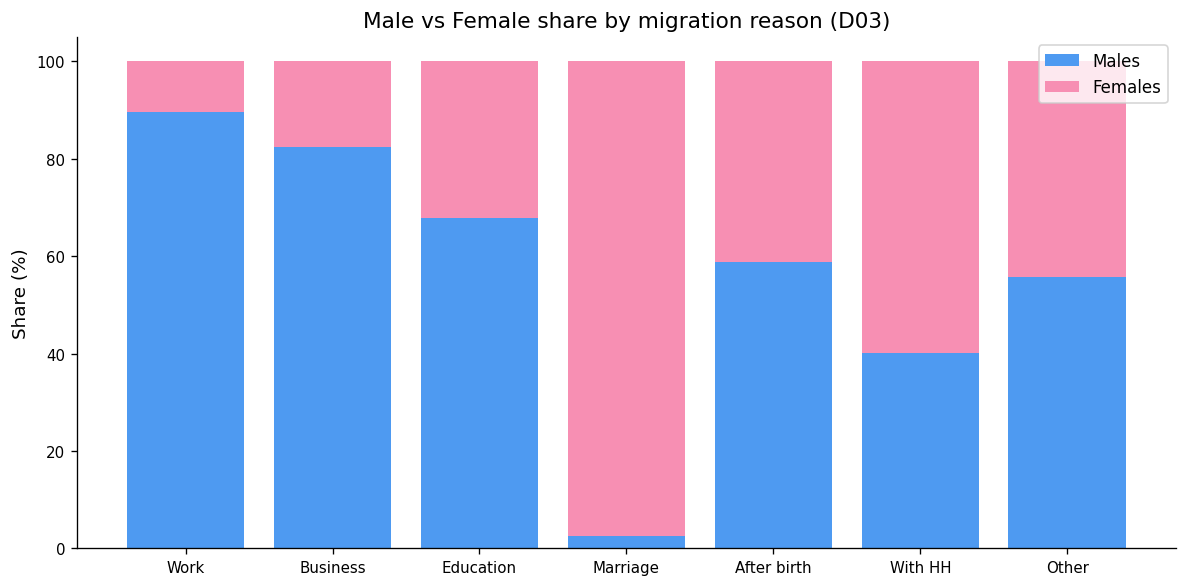

Sex ratio (F per 1000 M):
  Work           : 116
  Business       : 214
  Education      : 474
  Marriage       : 37652
  After birth    : 701
  With HH        : 1497
  Other          : 795


In [11]:
sex_data = []
for r_col, label in zip(
    ['Persons_Work','Persons_Business','Persons_Education',
     'Persons_Marriage','Persons_MoveAfterBirth','Persons_MoveWithHH','Persons_Other'],
    ['Work','Business','Education','Marriage','After birth','With HH','Other']
):
    m_col = r_col.replace('Persons_','Males_')
    f_col = r_col.replace('Persons_','Females_')
    total = df[r_col].sum()
    males = df[m_col].sum()
    fems  = df[f_col].sum()
    sex_data.append({'Reason': label, 'Males': males/total*100, 'Females': fems/total*100,
                     'SR': fems/males*1000})

sdf = pd.DataFrame(sex_data)

fig, ax = plt.subplots(figsize=(10, 5))
x = range(len(sdf))
ax.bar(x, sdf['Males'],   label='Males',   color='#4e9af1')
ax.bar(x, sdf['Females'], label='Females', bottom=sdf['Males'], color='#f78fb3')
ax.set_xticks(list(x))
ax.set_xticklabels(sdf['Reason'])
ax.set_ylabel('Share (%)')
ax.set_title('Male vs Female share by migration reason (D03)')
ax.legend()
plt.tight_layout()
plt.show()

print("Sex ratio (F per 1000 M):")
for _, row in sdf.iterrows():
    print(f"  {row['Reason']:<15}: {row['SR']:.0f}")


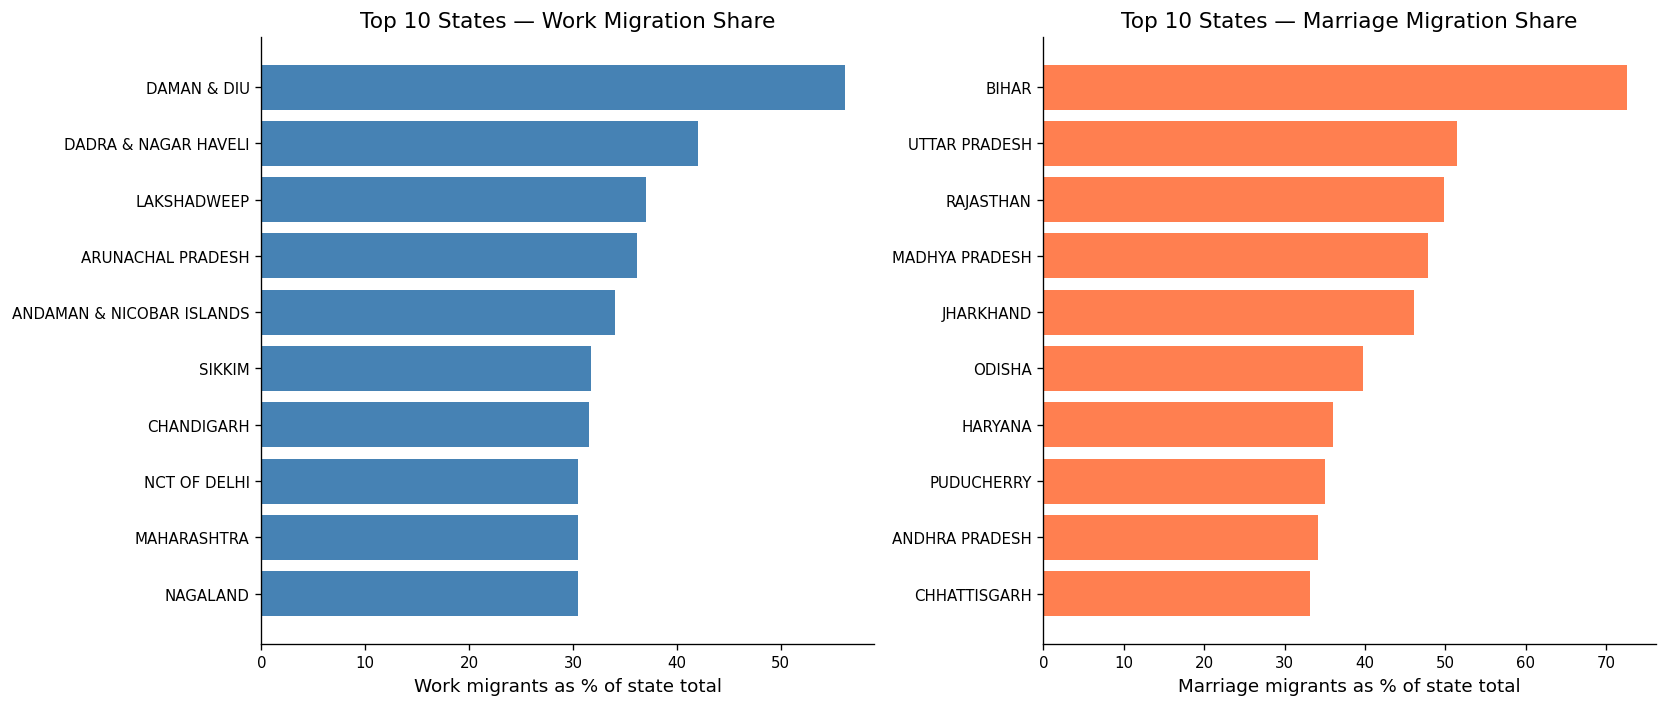

In [12]:
reason_cols = ['Persons_Work','Persons_Business','Persons_Education',
               'Persons_Marriage','Persons_MoveAfterBirth','Persons_MoveWithHH','Persons_Other']

state_reasons = df.groupby('AreaName')[reason_cols].sum()
state_reasons['Total'] = state_reasons.sum(axis=1)
state_reasons['WorkShare']     = state_reasons['Persons_Work']     / state_reasons['Total'] * 100
state_reasons['MarriageShare'] = state_reasons['Persons_Marriage'] / state_reasons['Total'] * 100

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

top_work = state_reasons['WorkShare'].sort_values(ascending=False).head(10)
axes[0].barh(top_work.index[::-1], top_work.values[::-1], color='steelblue')
axes[0].set_xlabel('Work migrants as % of state total')
axes[0].set_title('Top 10 States — Work Migration Share')

top_mar = state_reasons['MarriageShare'].sort_values(ascending=False).head(10)
axes[1].barh(top_mar.index[::-1], top_mar.values[::-1], color='coral')
axes[1].set_xlabel('Marriage migrants as % of state total')
axes[1].set_title('Top 10 States — Marriage Migration Share')

plt.tight_layout()
plt.show()


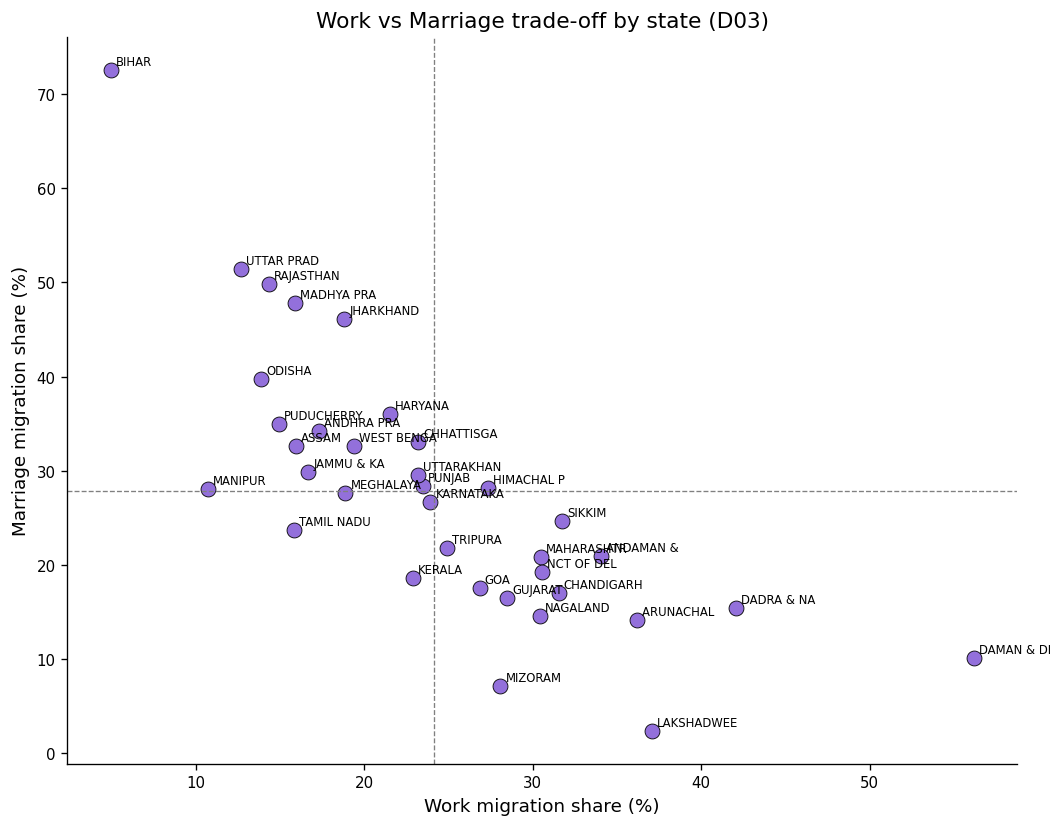

In [13]:
fig, ax = plt.subplots(figsize=(9, 7))
ax.scatter(state_reasons['WorkShare'], state_reasons['MarriageShare'],
           s=80, color='mediumpurple', edgecolors='black', linewidths=0.5)
for state, row in state_reasons.iterrows():
    ax.annotate(state[:10], (row['WorkShare'], row['MarriageShare']),
                fontsize=7, xytext=(3, 3), textcoords='offset points')
ax.set_xlabel('Work migration share (%)')
ax.set_ylabel('Marriage migration share (%)')
ax.set_title('Work vs Marriage trade-off by state (D03)')
ax.axhline(state_reasons['MarriageShare'].mean(), color='gray', linestyle='--', linewidth=0.8)
ax.axvline(state_reasons['WorkShare'].mean(),     color='gray', linestyle='--', linewidth=0.8)
plt.tight_layout()
plt.show()


## 7. Export

In [14]:
keep = [
    'AreaName','LastResidence',
    'Persons_Total','Males_Total','Females_Total',
    'Persons_Work','Males_Work','Females_Work',
    'Persons_Business','Males_Business','Females_Business',
    'Persons_Education','Males_Education','Females_Education',
    'Persons_Marriage','Males_Marriage','Females_Marriage',
    'Persons_MoveAfterBirth','Males_MoveAfterBirth','Females_MoveAfterBirth',
    'Persons_MoveWithHH','Males_MoveWithHH','Females_MoveWithHH',
    'Persons_Other','Males_Other','Females_Other'
]
df_final = df[[c for c in keep if c in df.columns]].reset_index(drop=True)

print(f"Shape  : {df_final.shape}")
print(f"Nulls  : {df_final.isnull().sum().sum()}")
print(f"Total  : {df_final['Persons_Total'].sum():,}")

df_final.to_csv("D03_cleaned.csv", index=False)
print("Saved -> D03_cleaned.csv")
df_final.head(10)


Shape  : (1208, 26)
Nulls  : 0
Total  : 55,246,933
Saved -> D03_cleaned.csv


,AreaName,LastResidence,Persons_Total,Males_Total,Females_Total,Persons_Work,Males_Work,Females_Work,Persons_Business,Males_Business,...,Females_Marriage,Persons_MoveAfterBirth,Males_MoveAfterBirth,Females_MoveAfterBirth,Persons_MoveWithHH,Males_MoveWithHH,Females_MoveWithHH,Persons_Other,Males_Other,Females_Other
0,JAMMU & KASHMIR,Himachal Pradesh,8609,2688,5921,726,643,83,109,74,...,4129,72,49,23,1470,601,869,1801,1089,712
1,JAMMU & KASHMIR,Punjab,43938,12318,31620,3804,3237,567,816,708,...,23225,618,387,231,7212,3162,4050,7275,4057,3218
2,JAMMU & KASHMIR,Chandigarh,611,249,362,88,73,15,7,7,...,147,26,13,13,183,71,112,137,69,68
3,JAMMU & KASHMIR,Uttarakhand,3180,1633,1547,447,390,57,37,29,...,304,42,26,16,1180,393,787,1053,702,351
4,JAMMU & KASHMIR,Haryana,5987,2744,3243,627,540,87,79,63,...,1089,141,87,54,1883,695,1188,1933,1192,741
5,JAMMU & KASHMIR,NCT of Delhi,5269,2316,2953,991,911,80,85,70,...,1490,205,112,93,1259,544,715,1088,582,506
6,JAMMU & KASHMIR,Rajasthan,6079,3190,2889,971,822,149,67,50,...,472,74,40,34,2108,720,1388,2034,1317,717
7,JAMMU & KASHMIR,Uttar Pradesh,20190,11520,8670,4393,3812,581,489,413,...,1885,294,172,122,5997,2149,3848,6386,4436,1950
8,JAMMU & KASHMIR,Bihar,13200,6998,6202,3452,3039,413,267,206,...,2245,143,76,67,3507,1350,2157,3144,1983,1161
9,JAMMU & KASHMIR,Sikkim,109,52,57,28,26,2,1,1,...,13,5,1,4,35,11,24,18,8,10
